<a id='Top'></a>

# WSI patch examples<a class='tocSkip'></a>

In [1]:
%load_ext watermark

import os
import sys

import torchvision
import matplotlib.pyplot as plt
from wsipre import slide, show

# Make modules in "src" dir visible
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(os.path.join(project_dir, 'src'))

import utils

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Example-WSIs" data-toc-modified-id="Example-WSIs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Example WSIs</a></span><ul class="toc-item"><li><span><a href="#Download-files" data-toc-modified-id="Download-files-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Download files</a></span></li><li><span><a href="#Create-images-and-save-to-files" data-toc-modified-id="Create-images-and-save-to-files-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Create images and save to files</a></span></li><li><span><a href="#Remove-example-WSIs" data-toc-modified-id="Remove-example-WSIs-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Remove example WSIs</a></span></li></ul></li><li><span><a href="#Example-patches" data-toc-modified-id="Example-patches-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example patches</a></span><ul class="toc-item"><li><span><a href="#Instantiate-DataLoader" data-toc-modified-id="Instantiate-DataLoader-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Instantiate <code>DataLoader</code></a></span></li><li><span><a href="#Show-patches-and-save-to-files" data-toc-modified-id="Show-patches-and-save-to-files-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Show patches and save to files</a></span></li></ul></li></ul></div>

# Example WSIs

Unfortunately, OpenCV-Python's API has changed between the version used to develop my [`wsipre`](https://github.com/luisvalesilva/wsipre) package (v3.4.4.19) and the newer version used in this project (v4.2.0).

Eventually, I should release a new `wsipre` version to tackle this, but here just write a quick wrapper to fix the problem (`cv2.findContours` now outputs a 2 instead of a 3-tuple). Also, take this opportunity to add some methods used here below.

In [2]:
import numpy as np
import cv2
from PIL import Image
from skimage import morphology
import tissue

class SlideWrapper(slide.Slide):
    def __init__(self, filename):
        super().__init__(filename,
                         annotation_filename=None, xml_style=None)
        image = None
    
    def detect_tissue(self, downsampling_factor=64):
        # Get a downsample of the whole slide image (to fit in memory)
        downsampling_factor = min(
            self.level_downsamples, key=lambda x: abs(x - downsampling_factor))
        level = self.level_downsamples.index(downsampling_factor)

        slide = self.read_region((0, 0), level, self.level_dimensions[level])
        slide = np.array(slide)[:, :, :3]

        # Convert from RGB to HSV color space
        slide_hsv = cv2.cvtColor(slide, cv2.COLOR_BGR2HSV)

        # Compute optimal threshold values in each channel using Otsu algorithm
        _, saturation, _ = np.split(slide_hsv, 3, axis=2)

        mask = tissue.otsu_filter(saturation, gaussian_blur=True)

        # Make mask boolean
        mask = mask != 0

        mask = morphology.remove_small_holes(mask, area_threshold=5000)
        mask = morphology.remove_small_objects(mask, min_size=5000)

        mask = mask.astype(np.uint8)
        mask_contours, _ = cv2.findContours(
            mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        return mask_contours, slide, downsampling_factor

    def get_tissue_mask(self, downsampling_factor=64, polygon_type='area',
                        line_thickness=None):
        (mask_contours,
         self.downsampled_slide,
         self.downsampling_factor) = self.detect_tissue(downsampling_factor)

        mask = np.zeros(self.downsampled_slide.shape[:2])
        self.tissue_mask = self._draw_tissue_polygons(
           mask, mask_contours, polygon_type, line_thickness)
        self.tissue_label_map = {'background': 0, 'tissue': 1}
    
    def make_segmented_wsi(self):
        image = np.array(self.downsampled_slide)
        if np.max(image) > 1:
            image = image / 255.

        green = (0, 1, 0)
        color_map={0: None, 1: green}

        for label, color in color_map.items():
            if label == 0:
                continue
            idx = self.tissue_mask.astype(np.float32) == label
            image[idx] = color
        
        self.image = image

    def zoom_in(self, top_left=(1500, 1500), size=(600, 500)):
        self.get_tissue_mask(polygon_type='line', line_thickness=4)
        self.make_segmented_wsi()

        x1, y1 = top_left
        x2, y2 = size
        x2 += x1
        y2 += y1

        self.image = self.image[y1:y2, x1:x2, :]

    def save(self, file_name, compress=True):
        # Save image
        plt.imsave(file_name, self.image)

        if compress:
            # Compress
            image = Image.open(file_name)
            scaling_factor = 5
            image = image.resize(tuple(x // scaling_factor for x in image.size),
                                 Image.ANTIALIAS)
            image.save(file_name, optimize=True, quality=95)
            self.image = image

## Download files

Pick one example from each of the four highlighted cancer types (PRAD, KIRC, OV, and GBM) on the GDC Data Portal [repository](https://portal.gdc.cancer.gov/repository), add them to the cart, and download the respective manifest file. Then use the `gdg-client` to download the files.

In [13]:
! /opt/gdc-client download -d . -m ../data/gdc_manifest_20200512_114040_example_WSIs.txt

sh: /tmp/_MEIwdWhEb/libtinfo.so.5: no version information available (required by sh)
sh: /tmp/_MEIwdWhEb/libtinfo.so.5: no version information available (required by sh)
/tmp/_MEIwdWhEb/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
sh: /tmp/_MEIwdWhEb/libtinfo.so.5: no version information available (required by sh)
100% [###########################################################] Time: 0:00:00             ] ETA:  0:00:00                                          ] ETA:  0:00:0000:00                   ] ETA:  0:00:00#############################                   ] ETA:  0:00:00A:  0:00:00#######################  ] ETA:  0:00:00
100% [##############################################] Time: 0:00:00   4.95 GB/s 
100% [#################################################

## Create images and save to files

Load images, run and annotate the automatic tissue segmentation, and save to file.

In [4]:
! tree [0-9f]*/

2dacb59c-af40-4955-8682-ec1f92e5d6f9/
├── logs
│   └── TCGA-TP-A8TT-01Z-00-DX1.652EA809-D931-46EE-80C9-0551C16DF822.svs.parcel
└── TCGA-TP-A8TT-01Z-00-DX1.652EA809-D931-46EE-80C9-0551C16DF822.svs
47467b2f-88d2-49ab-b95a-231fff532cbb/
├── logs
│   └── TCGA-A3-A6NI-01Z-00-DX1.F7C8BE3C-D2B9-4374-BBB7-64C7CE11C0E1.svs.parcel
└── TCGA-A3-A6NI-01Z-00-DX1.F7C8BE3C-D2B9-4374-BBB7-64C7CE11C0E1.svs
4dc68288-9d6d-4071-852c-328ef959246a/
├── annotations.txt
├── logs
│   └── TCGA-02-0010-01Z-00-DX3.33a67e8f-8bb6-498a-8c39-88b893c80b9e.svs.parcel
└── TCGA-02-0010-01Z-00-DX3.33a67e8f-8bb6-498a-8c39-88b893c80b9e.svs
fd67d3cf-bda0-4ea6-aafc-4af0b0f6b5a6/
├── logs
│   └── TCGA-25-2397-01Z-00-DX1.B6FDE9A3-6A51-4A79-82CB-51ED37945A54.svs.parcel
└── TCGA-25-2397-01Z-00-DX1.B6FDE9A3-6A51-4A79-82CB-51ED37945A54.svs

4 directories, 9 files


In [5]:
wsi_paths = {
    'GBM':'4dc68288-9d6d-4071-852c-328ef959246a/TCGA-02-0010-01Z-00-DX3.33a67e8f-8bb6-498a-8c39-88b893c80b9e.svs',
    'PRAD':'2dacb59c-af40-4955-8682-ec1f92e5d6f9/TCGA-TP-A8TT-01Z-00-DX1.652EA809-D931-46EE-80C9-0551C16DF822.svs',
    'KIRC':'47467b2f-88d2-49ab-b95a-231fff532cbb/TCGA-A3-A6NI-01Z-00-DX1.F7C8BE3C-D2B9-4374-BBB7-64C7CE11C0E1.svs',
    'OV':'fd67d3cf-bda0-4ea6-aafc-4af0b0f6b5a6/TCGA-25-2397-01Z-00-DX1.B6FDE9A3-6A51-4A79-82CB-51ED37945A54.svs',
}

In [41]:
wsis = {}

for cancer_type, path in wsi_paths.items():
    wsis[cancer_type] = SlideWrapper(filename=path)
    wsis[cancer_type].get_tissue_mask(polygon_type='line', line_thickness=15)

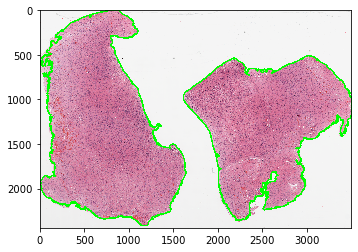

In [42]:
cancer_type = 'GBM'

wsis[cancer_type].make_segmented_wsi()
plt.imshow(wsis[cancer_type].image)
wsis[cancer_type].save(f'wsi_{cancer_type}.png')

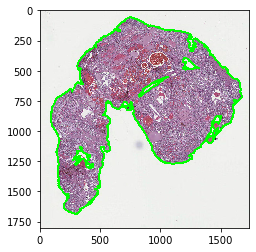

In [43]:
cancer_type = 'KIRC'

wsis[cancer_type].make_segmented_wsi()
plt.imshow(wsis[cancer_type].image)
wsis[cancer_type].save(f'wsi_{cancer_type}.png')

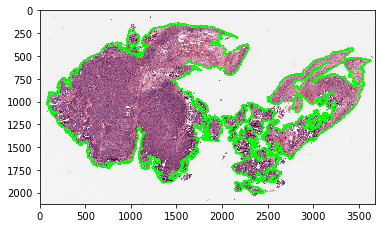

In [44]:
cancer_type = 'OV'

wsis[cancer_type].make_segmented_wsi()
plt.imshow(wsis[cancer_type].image)
wsis[cancer_type].save(f'wsi_{cancer_type}.png')

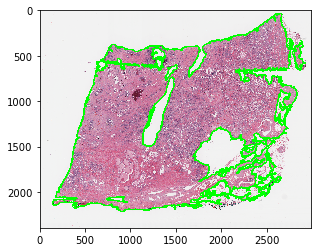

In [45]:
cancer_type = 'PRAD'

wsis[cancer_type].make_segmented_wsi()
plt.imshow(wsis[cancer_type].image)
wsis[cancer_type].save(f'wsi_{cancer_type}.png')

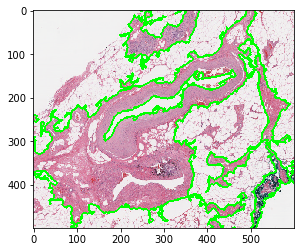

In [46]:
wsis[cancer_type].zoom_in(top_left=(2000, 1500), size=(600, 500))
plt.imshow(wsis[cancer_type].image)
wsis[cancer_type].save(f'wsi_{cancer_type}_zoom_in.png', compress=False)

## Remove example WSIs

In [14]:
! tree [0-9f]*/

2dacb59c-af40-4955-8682-ec1f92e5d6f9/
├── logs
│   └── TCGA-TP-A8TT-01Z-00-DX1.652EA809-D931-46EE-80C9-0551C16DF822.svs.parcel
└── TCGA-TP-A8TT-01Z-00-DX1.652EA809-D931-46EE-80C9-0551C16DF822.svs
47467b2f-88d2-49ab-b95a-231fff532cbb/
├── logs
│   └── TCGA-A3-A6NI-01Z-00-DX1.F7C8BE3C-D2B9-4374-BBB7-64C7CE11C0E1.svs.parcel
└── TCGA-A3-A6NI-01Z-00-DX1.F7C8BE3C-D2B9-4374-BBB7-64C7CE11C0E1.svs
4dc68288-9d6d-4071-852c-328ef959246a/
├── annotations.txt
├── logs
│   └── TCGA-02-0010-01Z-00-DX3.33a67e8f-8bb6-498a-8c39-88b893c80b9e.svs.parcel
└── TCGA-02-0010-01Z-00-DX3.33a67e8f-8bb6-498a-8c39-88b893c80b9e.svs
fd67d3cf-bda0-4ea6-aafc-4af0b0f6b5a6/
├── logs
│   └── TCGA-25-2397-01Z-00-DX1.B6FDE9A3-6A51-4A79-82CB-51ED37945A54.svs.parcel
└── TCGA-25-2397-01Z-00-DX1.B6FDE9A3-6A51-4A79-82CB-51ED37945A54.svs

4 directories, 9 files


In [15]:
! rm -r 2dacb59c-af40-4955-8682-ec1f92e5d6f9/

In [16]:
! rm -r 47467b2f-88d2-49ab-b95a-231fff532cbb/

In [17]:
! rm -r 4dc68288-9d6d-4071-852c-328ef959246a/

In [18]:
! rm -r fd67d3cf-bda0-4ea6-aafc-4af0b0f6b5a6/

# Example patches

Use the PyTorch `DataLoader`: shows example patches with the data augmentation transformations.

## Instantiate `DataLoader`

In [25]:
dataloaders = utils.get_dataloaders(
    data_location='/mnt/dataA/TCGA/processed/',
    labels_file='../data/labels.tsv',
    modalities=['wsi'],
    wsi_patch_size=299,
    n_wsi_patches=5,
    batch_size=2,
    return_patient_id=True,
)

Excluding 2192 patient(s) missing all data.
Excluding 279 patient(s) missing all data.
Excluding 234 patient(s) missing all data.
Data modalities:
   wsi

Dataset sizes (# patients):
   train: 6688
   val: 830
   test: 858

Batch size: 2


## Show patches and save to files

In [26]:
plt.rcParams["figure.figsize"] = (15, 15)

In [27]:
data, _, _, pids = next(iter(dataloaders['train']))

In [28]:
data['wsi'].shape

torch.Size([2, 5, 3, 299, 299])

In [32]:
figs = {}

for i in range(2):
    figs[pids[i]] = torchvision.utils.make_grid(
        data['wsi'][i], nrow=5, padding=10, pad_value=1.).permute(1, 2, 0)

TCGA-PE-A5DC


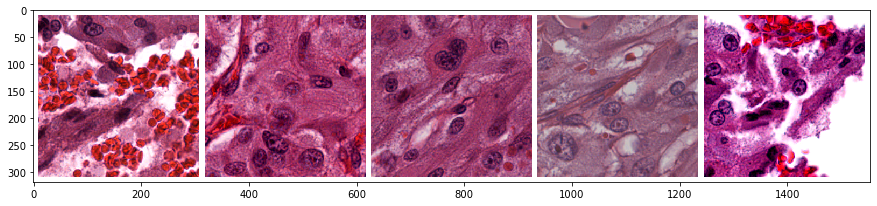

In [33]:
pid = pids[0]

print(pid)
plt.imshow(figs[pid])

TCGA-DD-AACY


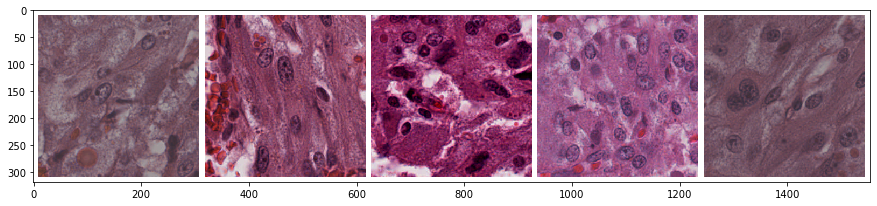

In [34]:
pid = pids[1]

print(pid)
plt.imshow(figs[pid])

In [35]:
for pid in figs:
    plt.imsave(f'wsi_patches_{pid}.png', figs[pid].numpy())

# Watermark<a class='tocSkip'></a>

In [3]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

numpy       1.18.1
cv2         4.2.0
PIL.Image   7.0.0
torchvision 0.5.0

CPython 3.6.7
IPython 7.11.1

last updated: Tue Jul 28 2020


[Top of the page](#Top)